In [2]:
import time
import os
import sys
import pyvisa
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import json
import pickle

### NOTE
If the fucntion `acq_data()` doesn't work, try the following (in this order):
0) Check device connection in NI-VISA. If the device is visible try querying *IDN? in the NI-VISA software.
* If No connection OR connected but query fails, do:
1) turn OFF oscilloscope
2) remove USB
3) close / restart notebook
4) turn ON oscilloscope
5) connect USB
5) check device connection in NI-VISA

Check step 0) again

## Helper functions

In [3]:
def device_info(instrument):
    """
    Queries and prints information about the connected instrument.

    Args:
        instrument (pyvisa.resources.Resource): The PyVISA instrument object.
    """
    device = instrument.query('*IDN?')
    brand, model, SN, info = device.split(',')
    print(f"Connected to :")
    print(f"        Brand : {brand}")
    print(f"        Model : {model}")
    print(f"Serial/Number : {SN},  {info}")
    
def scope_settings(scope, input_channels, which="acq"):
    """
    Applies general scope settings like waveform intensity, channel scale,
    impedance, and offset.

    Args:
        scope (pyvisa.resources.Resource): The PyVISA instrument object for the oscilloscope.
        which (str, optional): Determines offset setting. "acq" for 0V offset,
                                "display" or "disp" for pre-defined offsets. Defaults to "acq".
    Raises:
        ValueError: If 'which' argument is not 'acq' or 'disp'.
    """
    ALL_CHANNELS = ["CHANnel1", "CHANnel2", "CHANnel3", "CHANnel4"]
    scope.write(":DISPlay:INTensity:WAVeform 90") # how visible is the wave (transparency/alpha) on oscilloscope
    for channel, offset in zip(input_channels, [-6, 0, 6]):
        scope.write(f":{channel}:DISPlay 1")
        scope.write(f":{channel}:SCALe 5 V") # Scale amplitude V/div
        scope.write(f":{channel}:IMPedance FIFTY") # Set impedance 'FIFTY' for 50 Ohm, or ONEM for 1 mega Ohm -- A lowpass filter
        # Set offsets
        if which == "acq":
            scope.write(f":{channel}:OFFset 0") 
        elif which == "display" or which =="disp":
            scope.write(f":{channel}:OFFset {offset}")
        else:
            raise ValueError(f"    arg 'wich' has to be   'acq'  for acquire, or  'disp'  for display")
    for channel in ALL_CHANNELS:
        if channel not in input_channels:
            scope.write(f":{channel}:DISPlay 0")

## Test if connecting to OSC works
If this fails, see the **NOTE** in the beginning of document

In [4]:
rm = pyvisa.ResourceManager(); print(rm) # see directory for reource manager (?)
res = rm.list_resources(); print("Resources : ", res) # See which resources are available (USB etc.)
USB_resource = res[0]
inst = rm.open_resource(USB_resource) # In my case the index 0 is the USB device
# time.sleep(1)
# device = inst.query("*IDN?") # Then, you query the device with the following message: '\*IDN?'. Which is the standard GPIB message for “what are you?”
device_info(inst)
inst.close()

Resource Manager of Visa Library at C:\WINDOWS\system32\visa32.dll
Resources :  ('USB0::0x2A8D::0x1766::MY56311274::INSTR', 'ASRL3::INSTR', 'ASRL4::INSTR')
Connected to :
        Brand : KEYSIGHT TECHNOLOGIES
        Model : DSO-X 3024T
Serial/Number : MY56311274,  07.20.2017102614



# The function

In [5]:
def acq_data(resource_name, timebase_scale = 100e-6, datatype="16bit"):
    """
    Connects to the oscilloscope, configures it for a single acquisition
    by setting the specified timebase scale, and then extracts waveform data
    from three specified channels.

    Args:
        resource_name (str): The VISA address of the oscilloscope.
        timebase_scale (float): The horizontal scale in seconds per division (s/div) [default: 100e-6s].

    Returns:
        dict: A dictionary where keys are channel names ('CHANnel1', 'CHANnel2', 'CHANnel3')
              and values are dictionaries containing 'raw_data', 'voltages', 'times',
              and 'preamble' information for that channel.
              Returns an empty dictionary if connection or acquisition fails.
    """
    
    assert datatype in ["8bit", "16bit", 
                        # "ascii", 
                        ], f"Datatype has to be one of  ['8bit', '16bit', 'ascii']  You used  {datatype}"
    IS_BIG_ENDIAN = False
    if datatype == "8bit":
        FORMAT = "BYTE"
        DATATYPE = "B"
    elif datatype == "16bit":
        FORMAT = "WORD"
        DATATYPE = "H"
        # IS_BIG_ENDIAN = True
    # elif datatype == "ascii":
    #     FORMAT = "ASCii"
    #     DATATYPE = "f"
    else:
        print(f"Unkown datatype supplied : {datatype}")
    print(f"   Get data from format : {datatype}")
    rm = None
    scope = None
    acquired_data = {}
    
    # Define the channels to read directly within the function
    CHANNELS_TO_READ = [
        # "CHANnel1", 
        "CHANnel2", 
        "CHANnel3",
        "CHANnel4"
        ] 
    
    try:
        rm = pyvisa.ResourceManager()
        
        print(f"Attempting to connect to: {resource_name}")
        scope = rm.open_resource(resource_name)
        device_info(scope) # Call user's device_info function
        
        scope.write("*CLS") # Clear any previous errors
        # scope.write("*RST") # Reset OSC
        time.sleep(0.1)
        
        scope_settings(scope, CHANNELS_TO_READ, which="disp") # Set settings for each channel
        scope.query('*OPC?') # Are you ready?
        
        
        # --- Set Timebase Scale (from argument) ---
        # print(f"Setting Timebase Scale to: {timebase_scale:.2e} s/div.")
        scope.write(f":TIMebase:SCALe {timebase_scale}") # Set horizontal scale based on argument
        qres = float(scope.query(":TIMebase:SCAle?"))
        print(f"Timebase scale       : {qres:.2e} s/div")
        
        scope.write(":TIMebase:REFerence CENTer")
        qres = scope.query(":TIMebase:REFerence?")[:-1]
        print(f"Timebase ref         : {qres}")
        
        
        
        # --- Configure Trigger ---
        scope.write(":TRIGger:MODE GLITch")
        qres = scope.query(":TRIGger:MODE?")[:-1]
        print(f"Trigger mode         : {qres}")
        
        scope.write(":TRIGger:EDGE:SOURce CHANnel3") # CHAN-3 is the heralding source
        qres = scope.query(":TRIGger:EDGE:SOURce?")[:-1]
        print(f"Trigger source       : {qres}")
        
        scope.write(":TRIGger:EDGE:LEVel 2") # Set Trigger level to 2 V
        qres = float(scope.query(":TRIGger:EDGE:LEVel?"))
        print(f"Trigger edge level   : {qres} V")
        
        # scope.write(":TRIGger:EDGE:SLOpe POSitive")
        qres = scope.query(":TRIGger:EDGE:SLOpe?")[:-1]
        print(f"Trigger edge slope   : {qres}")
        
        
        # Configure acquisition
        scope.write(":ACQuire:TYPE NORMal")
        qres = scope.query(":ACQuire:TYPE?")[:-1]
        print(f"Acquire type         : {qres}")
        
        # --- Configure Waveform Transfer ---
        scope.write(":WAVeform:BYTeorder LSBfirst") # least significant bit first (default) equivalent to 'little-endian'
        qres = scope.query(":WAVeform:BYTeorder?")[:-1]
        print(f"Waveform byte-order  : {qres}")
        
        scope.write(f":WAVeform:FORMat {FORMAT}")
        qres = scope.query(":WAVeform:FORMat?")[:-1]
        print(f"Waveform format      : {qres}")
        
        
        
        
        
        # Set amount of points for the data transfer
        # Options: "MAXimum", "RAW", "NORMal"
        # "MAXimum" uses "RAW" if available (oscilloscpe not running), and otherwise "NORMal" (p. 1008)
        scope.write(f":WAVeform:POINts:MODE RAW") # Set amount of datapoints
        qres = scope.query(":WAVeform:POINts:MODE?")[:-1]
        print(f"Waveform points mode : {qres}")
        
        
        # scope.write(":AUToscale")
        # Ensure scope is stopped before acquiring data
        scope.write(":STOP") # :SINGle and :STOP have a difference in sample rate
        time.sleep(0.1)
        # scope.query("*OPC?")
        # time.sleep(0.1)
        # qres = int(scope.query(":WAVeform:POINts?"))
        # print(f"Waveform points      : {qres}")
        
        
        print("Single acquisition complete. Oscilloscope is stopped and holding data.")
        # test = scope.query_binary_values(":CURV?", datatype=DATATYPE, container=np.ndarray)
        
        
        # --- Oscilloscope is now stopped and holding the "screenshot" data ---
        # --- Extract Data from all channels ---
        acquired_data = {}
        for channel in CHANNELS_TO_READ:
            print(f"\n  Extracting data from {channel}...")
            scope.write(f":WAVeform:SOURce {channel}")
            scope.query("*OPC?")
                
            # time.sleep(0.05) # Give the scope a moment to switch channels context

            # Query preamble for the current channel
            # This preamble reflects the *actual* acquisition settings (sample rate, record length, etc.)
            preamble_string = scope.query(":WAVeform:PREamble?")
            preamble_list = preamble_string.split(',')  
            qres = scope.query("WAVeform:SOURce?")  
            print(f"    Preamble for {qres[:-1]}: {preamble_list}") # Print the list for inspection
            
            # qres = scope.query("CURV?")
            # print(f"CURV : {qres}")
            
            try:
                num_points_actual = int(preamble_list[2])      # Total number of points acquired
                x_increment_actual = float(preamble_list[4]) # Actual time per point (1/SampleRate_Actual)
                x_origin_actual = float(preamble_list[5])    # Start time of the waveform
                y_increment_actual = float(preamble_list[7]) # Volts per raw data unit
                y_origin_actual = float(preamble_list[8])    # Vertical offset in Volts
                y_reference_actual = float(preamble_list[9]) # Vertical reference in raw units
                print(f"    Actual Acq: N_pts={num_points_actual}, Xinc={x_increment_actual:.2e}s, Yinc={y_increment_actual:.2e}V")
                print(f"                Xorig={x_origin_actual:.2e}, Yorig={y_origin_actual:.2e}")
            except (IndexError, ValueError) as e:
                print(f"    ERROR: Failed to parse preamble for {channel}. Check manual and its structure. {e}")
                raise # Critical error, cannot interpret data without this
            
            # Read raw binary waveform data for the entire record
            raw_data = scope.query_binary_values(
                message=":WAVeform:DATA?",
                datatype=DATATYPE,
                container=np.array,
                data_points=num_points_actual, # expected number of data-points
            )
            scope.query("*OPC?") 
            
            print(f"    Raw data points extracted from {channel}: {len(raw_data)}")

            if len(raw_data) == 0:
                print(f"    WARNING: No data received from {channel}. Check acquisition and trigger settings.")
                continue # Skip processing for this channel if no data
                
            # Convert raw data to actual voltage values
            voltages = y_origin_actual + (raw_data - y_reference_actual)*y_increment_actual 

            # Create the time axis for this waveform
            times = x_origin_actual + np.arange(0, len(voltages))*x_increment_actual

            acquired_data[channel] = {
                'raw_data': raw_data,
                'voltages': voltages,
                'times': times,
                'preamble': {
                    'num_points': num_points_actual,
                    'x_increment': x_increment_actual,
                    'x_origin': x_origin_actual,
                    'y_increment': y_increment_actual,
                    'y_origin': y_origin_actual,
                    'y_reference': y_reference_actual
                }
            }
    
        
    except pyvisa.errors.VisaIOError as e:
        print(f"\nVISA Error: {e}")
        print("Please check connection and settings. Common issues:")
        print("  - Oscilloscope is not connected or powered on.")
        print("  - 'OSCILLOSCOPE_VISA_ADDRESS' is incorrect. Use 'rm.list_resources()' to verify.")
        print("  - VISA backend (NI-VISA, pyvisa-py) is not installed or configured.")
        print("  - The command to query memory depth might be incorrect for your scope.")
        print("  - The desired sample rate might be too high for the scope's capabilities.")
        # scope.close()
    except Exception as e:
        print(f"\nAn unexpected error occurred: {e}")
        # scope.close()
    finally:
        if scope and scope.session:
            # time.sleep(2)
            # scope_settings(scope, which="display") # Call user's scope_settings function for acquisition settings

            scope.write(":RUN") # Return to run mode for live viewing
            scope.close()
            print("\nConnection closed.")
        
    return acquired_data 
DATA = acq_data(USB_resource, timebase_scale=500e-9, datatype="16bit")

   Get data from format : 16bit
Attempting to connect to: USB0::0x2A8D::0x1766::MY56311274::INSTR
Connected to :
        Brand : KEYSIGHT TECHNOLOGIES
        Model : DSO-X 3024T
Serial/Number : MY56311274,  07.20.2017102614

Timebase scale       : 5.00e-07 s/div
Timebase ref         : CENT
Trigger mode         : GLIT
Trigger source       : CHAN3
Trigger edge level   : 2.0 V
Trigger edge slope   : POS
Acquire type         : NORM
Waveform byte-order  : LSBF
Waveform format      : WORD
Waveform points mode : RAW
Single acquisition complete. Oscilloscope is stopped and holding data.

  Extracting data from CHANnel2...
    Preamble for CHAN2: ['+1', '+0', '+12500', '+1', '+4.00000000E-010', '-2.50000000E-006', '+0', '+7.85175900E-004', '-6.00000000E+000', '+32768\n']
    Actual Acq: N_pts=12500, Xinc=4.00e-10s, Yinc=7.85e-04V
                Xorig=-2.50e-06, Yorig=-6.00e+00
    Raw data points extracted from CHANnel2: 12500

  Extracting data from CHANnel3...
    Preamble for CHAN3: ['+1',

### Below are plots of for the screenshot

   Get data from format : 16bit
Attempting to connect to: USB0::0x2A8D::0x1766::MY56311274::INSTR
Connected to :
        Brand : KEYSIGHT TECHNOLOGIES
        Model : DSO-X 3024T
Serial/Number : MY56311274,  07.20.2017102614

Timebase scale       : 5.00e-03 s/div
Timebase ref         : CENT
Trigger mode         : GLIT
Trigger source       : CHAN3
Trigger edge level   : 2.0 V
Trigger edge slope   : POS
Acquire type         : NORM
Waveform byte-order  : LSBF
Waveform format      : WORD
Waveform points mode : RAW
Single acquisition complete. Oscilloscope is stopped and holding data.

  Extracting data from CHANnel2...
    Preamble for CHAN2: ['+1', '+0', '+1000000', '+1', '+5.00000000E-008', '-2.50000483E-002', '+0', '+7.85175900E-004', '-6.00000000E+000', '+32768\n']
    Actual Acq: N_pts=1000000, Xinc=5.00e-08s, Yinc=7.85e-04V
                Xorig=-2.50e-02, Yorig=-6.00e+00
    Raw data points extracted from CHANnel2: 1000000

  Extracting data from CHANnel3...
    Preamble for CHAN3: 

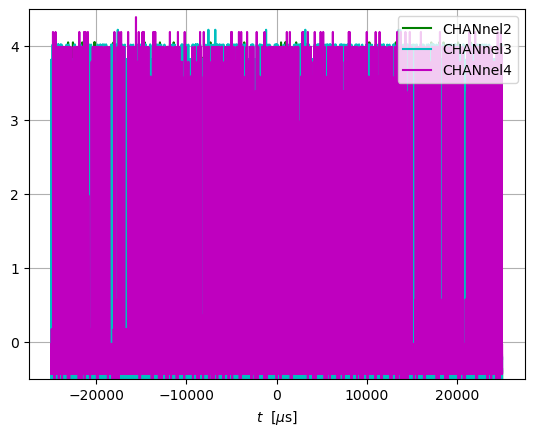

In [ ]:
TBASE_SCALE = 5e-3 # s/div -- adjust this to as neccesary
DATA = acq_data(USB_resource, timebase_scale=TBASE_SCALE, datatype="16bit")
# save data to work remote without oscilloscope

with open(f"data_tscale_{TBASE_SCALE:.2e}.pkl", "wb") as file: # "wb": write binary
    print(f"save data locally using Pickle!")
    pickle.dump(DATA, file)

with open(f"data_tscale_{TBASE_SCALE:.2e}.pkl", "rb") as file: # "rb": read binary
    print(f"Un-pickle!")
    DATA = pickle.load(file)
    
fig, ax = plt.subplots()
COLORS = {
    "CHANnel1": "y",
    "CHANnel2": "g", 
    "CHANnel3": "c", 
    "CHANnel4": "m"}
for CHANNEL in DATA:
    t = DATA[CHANNEL]["times"]
    vol = DATA[CHANNEL]["voltages"]
    ax.plot(t*1e6, vol, label=CHANNEL, color=COLORS[CHANNEL])
ax.grid()
ax.set_xlabel(r"$t$  [$\mu$s]")
# ax.set_xlim((-50*1e-3, 50*1e-3))
ax.set_ylim([-0.5, 4.5])
ax.legend(loc="upper right")

   Get data from format : 8bit
Attempting to connect to: USB0::0x2A8D::0x1766::MY56311274::INSTR
Connected to :
        Brand : KEYSIGHT TECHNOLOGIES
        Model : DSO-X 3024T
Serial/Number : MY56311274,  07.20.2017102614

Timebase scale       : 5.00e-07 s/div
Timebase ref         : CENT
Trigger mode         : GLIT
Trigger source       : CHAN3
Trigger edge level   : 2.0 V
Trigger edge slope   : POS
Acquire type         : NORM
Waveform byte-order  : LSBF
Waveform format      : BYTE
Waveform points mode : RAW
Single acquisition complete. Oscilloscope is stopped and holding data.

  Extracting data from CHANnel2...
    Preamble for CHAN2: ['+0', '+0', '+12500', '+1', '+4.00000000E-010', '-2.50000000E-006', '+0', '+2.01005000E-001', '-6.00000000E+000', '+128\n']
    Actual Acq: N_pts=12500, Xinc=4.00e-10s, Yinc=2.01e-01V
                Xorig=-2.50e-06, Yorig=-6.00e+00
    Raw data points extracted from CHANnel2: 12500

  Extracting data from CHANnel3...
    Preamble for CHAN3: ['+0', '+

[(-1e-07, 1e-07)]

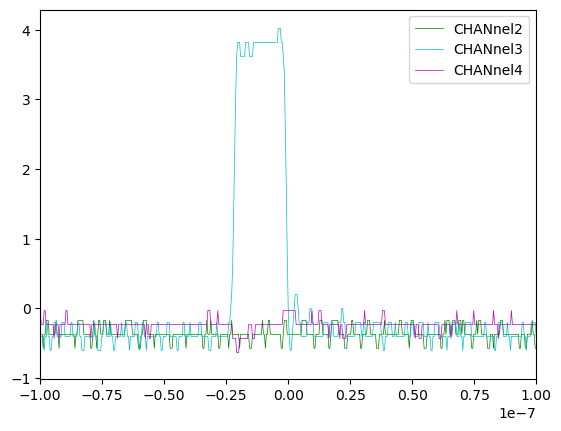

In [23]:
DATA = acq_data(USB_resource, timebase_scale=500e-9, datatype="8bit")

fig, ax = plt.subplots()
COLORS = {
    "CHANnel1": "y",
    "CHANnel2": "g", 
    "CHANnel3": "c", 
    "CHANnel4": "m"}
for channel in DATA:
    CHAN = DATA[channel]
    t = CHAN["times"]
    vol = CHAN["voltages"]
    ax.plot(t, vol, linewidth=0.5, label=channel, color=COLORS[channel])
    
ax.legend()
ax.set(xlim=(-100e-9, 100e-9))

# Repeat for X aount of times

## Mostly obsolete function for extracting numpy array from data_dict
In future this will be directly retreived from the data_dict

In [32]:
def extract_array(data_dict):
    data = []
    for channel in data_dict:
        if channel == list(data_dict.keys())[0]:
            t = data_dict[channel]["times"]
            data.append(t)
        vol = data_dict[channel]["voltages"]
        data.append(vol)
        
    return np.array(data).T



print(extract_array(DATA).shape)

(1000000, 4)


In [34]:
# @my_timer
def get_epochs(USB_resource, total_time, timebase_scale):
    # Determine amount of epochs using total time scale and the timebase scale
    total_epochs = int(total_time/timebase_scale)
    assert total_epochs >= 1, f"Total epochs should be at least 1 (was {total_epochs}).\n Check time inputs"
    
    # Store the original stdout
    original_stdout = sys.stdout
    
    # Open a null device to redirect output to
    # On Windows, use 'NUL'
    # On Linux/macOS, use '/dev/null'
    devnull = open(os.devnull, "w") # os.devnull works for all
    total_data = []
    for iter in tqdm(range(total_epochs), desc="Running epochs"):
        # Redirect stdout to devnull
        sys.stdout = devnull
        
        # Call your function here
        data_iter = acq_data(resource_name=USB_resource, timebase_scale=timebase_scale)
        data_arr = extract_array(data_iter) # convert to ndarray
        
        total_data.append(data_arr)
        
        
        # Restore stdout to its original state
        sys.stdout = original_stdout
        
        # print(f"WORKS!")
        # if iter == 3:
        #     break
    # print(total_epochs)
    
    print("DONE!")
    return total_data


start_time = time.time()
tot_data = get_epochs(USB_resource, total_time=100*1e-3, timebase_scale=500*1e-6)
end_time = time.time()

print(f"This took {end_time - start_time :.2f}s")
    

Running epochs:  94%|█████████▍| 188/200 [04:00<00:15,  1.28s/it]


VisaIOError: VI_ERROR_TMO (-1073807339): Timeout expired before operation completed.

In [35]:
tot_data

NameError: name 'tot_data' is not defined